# Imports Library:

In [4]:
import pandas as pd
import numpy as np
import contractions # To contraction words as 'don't' ---> 'do not'
import re  
import string
from termcolor import colored 
from tqdm import tqdm 
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning) 

#--------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report

# --------------------------
from scipy.special import softmax

# --------------------------
import matplotlib.pyplot as plt
import seaborn as sns  

# ---------------------------
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# ---------------------------
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertTokenizer,BertModel

# --------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,SpatialDropout1D
from tensorflow.keras.utils import to_categorical

#----------------------------
import nlpaug.augmenter.word.context_word_embs as aug

# ---------
import torch
import torch.nn as nn
import shutil
import sys
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
import joblib

### Load Dataset:

In [16]:
data = pd.read_csv("SamsungS23Ultra.csv")
data.head()

,Comment
0,Play on 🎮 with a super powerful processor and ...
1,I switched from the iPhone and am currently wa...
2,It was faster when I bought it. Now my usage ...
3,I bought a S24
4,I have a S24


### EDA: Exploratory Data Analysis

### Data Inspection:
Examine the structure and contents of the dataset
1. Extract the informations from the dataset and describes its each column values

In [17]:
print(colored("Dataset Information:", "cyan"))
print(data.info())
print(colored("\nDescriptions of dataset:", "magenta"))
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  2551 non-null   object
dtypes: object(1)
memory usage: 20.1+ KB
None

Descriptions of dataset:
       Comment
count     2551
unique    2524
top     Boring
freq         7


### Missing values checking:
1. Missing values checking and extract the rows having 'NAN' at least one column.
   If so, replace 'NAN' by appropriate methods

In [18]:
# Null values checking
print(colored("Number of Null values on each columns are:",'red'))
print(data.isnull().sum())
print(colored("\nRows having atleast one 'NAN':",'light_red'))
data[data.isnull().any(axis=1)]

Number of Null values on each columns are:
Comment    0
dtype: int64

Rows having atleast one 'NAN':


,Comment


This shows that dataset does not contain any null vales.

### Assign Sentiment to each comments using RoBERTa:
RoBERTa (Robustly optimized BERT) approach with MODEL = "cardiffnlp/twitter-roberta-base-sentiment",
labels each comments among one of the three labels {0: "Negative", 1: "Neutral", 2: "Positive"}.

In [19]:
# Define RoBERTa model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# Define assigning function
def Assign_Sentiment(text):
    input = tokenizer(text,return_tensors="pt",truncation=True,padding=True,max_length=512)
    output = model(**input)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    index = np.argmax(score)
    if index == 0:
        return 'Negative'
    elif index == 1:
        return 'Neutral'
    else:
        return 'Positive'

In [25]:
# Apply the function to the DataFrame
data['Sentiment'] = data['Comment'].apply(lambda text: Assign_Sentiment(text))
data.head()

,Comment,Sentiment
0,Play on 🎮 with a super powerful processor and ...,Positive
1,I switched from the iPhone and am currently wa...,Positive
2,It was faster when I bought it. Now my usage ...,Positive
3,I bought a S24,Neutral
4,I have a S24,Neutral


# Save the labeled data for future works:

In [ ]:
# Save labeled data
joblib.dump(data,'Labeled_Sentiment_data.csv')

['Labeled_Sentiment_data.csv']

# Sentiment wise inspect the comments:

In [26]:
# Positive comments
print(colored('Positve comments:','green'))
print(data['Comment'][data['Sentiment']=='Positive'][0:5])
# Neutral comments
print(colored("\nNeutral comments: ",'yellow'))
print(data['Comment'][data['Sentiment']=='Neutral'][0:5])
# Negative commnets
print(colored("\nNegative comments: ",'light_red'))
print(data['Comment'][data['Sentiment']=='Negative'][0:5])

Positve comments:
0    Play on 🎮 with a super powerful processor and ...
1    I switched from the iPhone and am currently wa...
2    It was faster when I bought it.  Now my usage ...
6                       Just bought s23 ultra today ❤️
9                           Watching on my S23 Ultra 🥰
Name: Comment, dtype: object

Neutral comments: 
3                                        I bought a S24
4                                          I have a S24
5     Does anyone know that 2023 they released s23 u...
7                                          Now astro 24
15                                     Watching on S24U
Name: Comment, dtype: object

Negative comments: 
8     Dust and Water Resistance is a scam. I took my...
10    Biggest POS phone ever made next to Apple garb...
12    hiii PLEASE IF ANYBODY CAN ASWEAR ME I DO A MI...
14                         Worthless mobile i ever hade
18                               I lost my phone help 😢
Name: Comment, dtype: object


# Sentiment Diostribution:

In [27]:
# Count of sentiments
print(colored('Counts of each sentiment: ','green'))
print(data['Sentiment'].value_counts())

Counts of each sentiment: 
Sentiment
Positive    1180
Neutral      834
Negative     537
Name: count, dtype: int64


### Plot sentiment distribution:

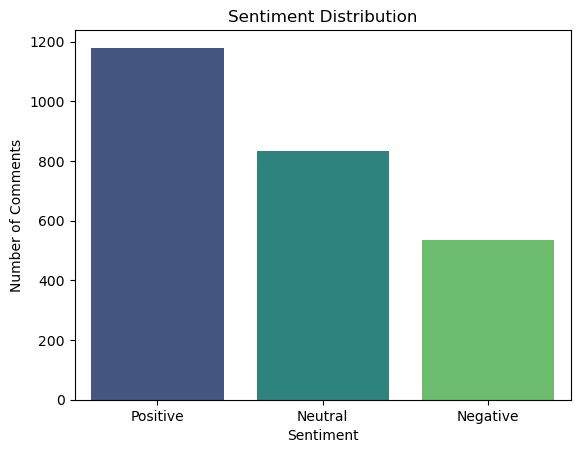

In [28]:
sns.countplot(x='Sentiment', data=data,palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

It is showing us that sentiment distribution associated with given comments is skewed.It is skew towards the positive
comments which is good for Samsung industry but the other classes(Negative,Neutral) impact are more important for this task purpose.
According to the comments of this trailer, Negative comments will play significant role for our further analysis and will give evidence of future marketing of Samsung Galaxy S23 ultra.

# Balancing Data:

In [29]:
# Sentiment class counts
print("Before Blancing: \n")
print(data['Sentiment'].value_counts())
# Major class count
majorclass_num = max(data['Sentiment'].value_counts())
print(colored('\nMajor class count: ','green'),majorclass_num)

Before Blancing: 

Sentiment
Positive    1180
Neutral      834
Negative     537
Name: count, dtype: int64

Major class count:  1180


### Data Augmentation using BERT:

In [53]:
# Load BERT base augmenter
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased',action='insert')

In [68]:
# Data augmentation
def DataAugmentation(df,augmenter,neu_samples,neg_samples,repetitions=1):
    # Extract the neutral and negative comments
    neutral_comments = df[df['Sentiment']=='Neutral'].reset_index(drop=True)
    negative_comments = df[df['Sentiment']=='Negative'].reset_index(drop=True)
    
    #---------------------
    # Augmenting newtral comments
    aug_neutral = []
   
    for i in tqdm(np.random.choice(len(neutral_comments),neu_samples,replace=False)):
        for _ in range(repetitions):
            text = neutral_comments['Comment'].iloc[i]
            aug_text = augmenter.augment(text)
            aug_neutral.append(aug_text[0])
    # Negative data dictionary
    Neutral_data = {'Comment':aug_neutral,'Sentiment': 'Neutral'}
    neu_df = pd.DataFrame(Neutral_data)
    #-----------------
    aug_negative = []
    for i in tqdm(np.random.choice(len(negative_comments),neg_samples,replace=False)):
        for _ in range(repetitions):
            text = negative_comments['Comment'].iloc[i]
            aug_text = augmenter.augment(text)
            aug_negative.append(aug_text[0])
    #  Neutral data dictionary
    Negative_data ={'Comment':aug_negative,'Sentiment': 'Negative'}
    neg_df = pd.DataFrame(Negative_data)

    # Final augmentation
    new_df = pd.concat([df,neg_df, neu_df])
    return shuffle(new_df).reset_index(drop=True)

In [70]:
# Augemented data
Aug_Data = DataAugmentation(data,augmenter,330,520) # neu_samples=330, neg_samples=520

100%|██████████| 520/520 [01:46<00:00,  4.88it/s]


# Save augmented final dataset:

In [82]:
# Save Augmented data
joblib.dump(Aug_Data,'Augmented_Lebel_Data.csv')

['Augmented_Lebel_Data.csv']

# Augmented data informations and its Sentiment distribution:

In [72]:
Aug_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401 entries, 0 to 3400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    3401 non-null   object
 1   Sentiment  3401 non-null   object
dtypes: object(2)
memory usage: 53.3+ KB


In [74]:
# Sentiment class counts
print("After Blancing: \n")
print(Aug_Data['Sentiment'].value_counts())
# Major class count
majorclass_num = max(Aug_Data['Sentiment'].value_counts())
print(colored('\nMajor class count: ','green'),majorclass_num)

After Blancing: 

Sentiment
Positive    1180
Neutral     1164
Negative    1057
Name: count, dtype: int64

Major class count:  1180


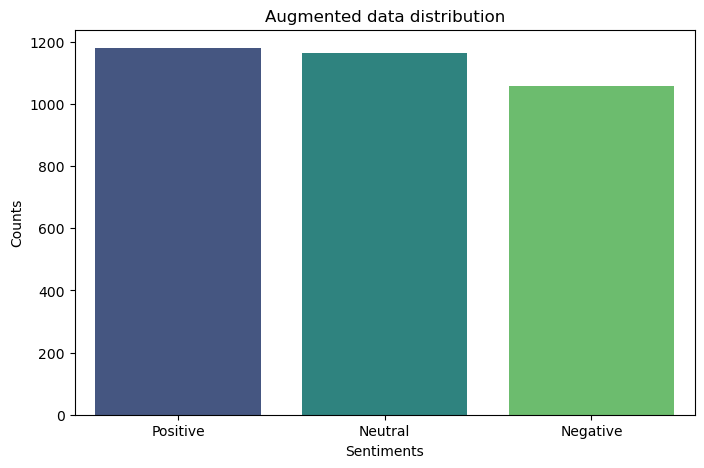

In [80]:
# Drawing distribution after data augmentation
plt.figure(figsize=(8,5))
sns.countplot(data=Aug_Data,x='Sentiment',palette='viridis')
plt.title('Augmented data distribution')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.show()


In [5]:
Final_data = joblib.load('Augmented_Lebel_Data.csv')
Final_data.head()

,Comment,Sentiment
0,The best smartphone in the world,Positive
1,3 so... xx what'a s new? xx xd,Neutral
2,Oh !so nothing new,Neutral
3,these two new nokia phones have been comparati...,Negative
4,hey bro this ad jingle is so very tacky [UNK],Negative


## Data Labeling:

In [6]:
label_map ={'Positive':2, 'Negative': 1,'Neutral':0}
Final_data['label'] = Final_data['Sentiment'].map(label_map)
display(Final_data.head(10))
display(Final_data.tail(10))

,Comment,Sentiment,label
0,The best smartphone in the world,Positive,2
1,3 so... xx what'a s new? xx xd,Neutral,0
2,Oh !so nothing new,Neutral,0
3,these two new nokia phones have been comparati...,Negative,1
4,hey bro this ad jingle is so very tacky [UNK],Negative,1
5,Change the design bro😅,Neutral,0
6,Love my Samsung ❤❤❤❤❤❤❤,Positive,2
7,i thought the girl was camila cabello,Neutral,0
8,My Infinix 2 years old is working in this year...,Positive,2
9,Kudos to SAMSUNG for giving powerful in all pa...,Positive,2


,Comment,Sentiment,label
3391,iPhone is better,Positive,2
3392,disappointed with samsung's decision to tempor...,Negative,1
3393,It's basically the same as my S22 Ultra just w...,Neutral,0
3394,not only the phone itself brings nothing new (...,Negative,1
3395,"God, it's so good, Can I catch it!❣️🧗",Positive,2
3396,that one nearby share market ain ’ t as no goo...,Negative,1
3397,It looks just like like my 22 ultra with small...,Neutral,0
3398,Hit like if you’re waiting for iPhone 15 series.,Neutral,0
3399,"can't lie , samsung are always innovative with...",Positive,2
3400,"I wish Samsung launched a 5.4"" screen sized p...",Neutral,0


### Extract Feature & target variable :


In [7]:
# Inputs text
comments = Final_data['Comment'].values
# Response for each text
labels = Final_data['label'].values 

# BERT tokenizer hyperparametrs:

In [8]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-03

# Defining BERT tokenizer:

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function that gives input ids and attention mask for each comment:

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,df,tokenizer,max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.comments = self.df['Comment']
        self.labels = self.df['label'].values

    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self,index):
        comment = str(self.comments[index])
        comment = " ".join(comment.split())
        label = int(self.df['label'].iloc[index])
        inputs = self.tokenizer.encode_plus(
            comment,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            truncation=True,
            return_attention_mask = True,
            return_tensors='pt'
        )

        return {
            'inputs_ids':inputs.input_ids.flatten(),
            'attention_mask':inputs.attention_mask.flatten(),
            'token_type_ids': inputs.token_type_ids.flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }

# Splitting dataset into train and validation set:

In [11]:
train_size = 0.7
train_df = Final_data.sample(frac=train_size,random_state=200).reset_index(drop=True)
val_df = Final_data.drop(train_df.index).reset_index(drop=True)


In [12]:
# Displaying train and validation data frame:
display(train_df.head())
display(val_df.head())

print(train_df.shape, val_df.shape)

,Comment,Sentiment,label
0,was this my dream fullfil,Neutral,0
1,Hopefully the reels will be better with the s2...,Positive,2
2,"What a crazy time, we had all this bad stuff g...",Positive,2
3,What a nice trailor,Positive,2
4,I enjoy watching the international they are pr...,Positive,2


,Comment,Sentiment,label
0,What a beautyyy❤,Positive,2
1,"SD 8 gen 2 more powerful than a15, and close t...",Positive,2
2,That's Awesome 😍😍😍😍,Positive,2
3,Thank you Samsung to be the same phone from th...,Positive,2
4,"Samsung always innovative , even is this ad 🔥🔥",Positive,2


(2381, 3) (1020, 3)


In [13]:
# Train and validation data frame containg input_ids, attention mask and targets:
train_dataset = CustomDataset(train_df,tokenizer,MAX_LEN)
valid_dataset = CustomDataset(val_df,tokenizer,MAX_LEN)

# Loading train and validation dataset into torch pipeline:

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE
)

val_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=VALID_BATCH_SIZE
)

# Define sentiment classifier using BERT:

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop0 = nn.Dropout(0.25)
        self.linear1 = nn.Linear(3072,512)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(512,3)
        
    def forward(self,input_ids,attention_mask):
        outputs = self.bert(input_ids,attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = torch.cat(tuple([last_hidden_state[:,i] for i in [-4,-3,-2,-1]]),dim=-1)
        x = self.drop0(pooled_output)
        x = self.relu1(self.linear1(x))
        x = self.drop1(x)
        x = self.linear2(x) 
        return x
        

# Train the classifier:

In [ ]:
# Initialize classifiers:
model = SentimentClassifier()

# Define the optimizer function:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
epochs = 10

# Define schedular to set optimizer parameters after each epochs
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# -----------TRAINING--------

for epoch in range(epochs):
    # TRAIN
    model.train()
    # Initialize progress bar
    train_loop = tqdm(train_data_loader, desc=f"Training Epoch {epoch+1}", leave=True)
    # Iterate over batches
    for batch in train_loop:
        optimizer.zero_grad()
        input_ids = batch['inputs_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        output = model(input_ids,attention_mask)
        loss = criterion(output,labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)       
        optimizer.step()

        train_loop.set_description(f'Training Epoch: {epoch}')
        train_loop.set_postfix(loss=loss.item())
    scheduler.step()

# Prediction on user input comments:

In [34]:
test_sample = 'My parrents will not allow to buy this phone for huge price but it has very good features'
original_label = 2
print(f'Test sample: {test_sample}')
print(f'Original label: {original_label}')

encode = tokenizer.encode_plus(
    test_sample,
    add_special_tokens=True,
    max_length = 256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

with torch.no_grad():
    preds = model(encode['input_ids'],encode['attention_mask'])
    preds = np.argmax(preds)
    output = preds.item()
    print(f'Prediction: {output}')

Test sample: My parrents will not allow to buy this phone for huge price but it has very good features
Original label: 2
Prediction: 2


# Save the model and tokenizer for future prediction and deploying the model:

In [23]:
# Save the trained model
torch.save(model, 'SentimentBERT_model_complete.pth')

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained('/user1/student/mtc/mtc2023/cs2326/Project_Works')